# Step 3: Using your Graph

In this third tutorial, we calculate an OD matrix as well as isochrones around a set of destinations. Our setting remains Reykjavik, Iceland, as we look at travel times along the network to churches.

In [1]:
import os, sys
import geopandas as gpd
import pandas as pd
import importlib
import networkx as nx
from shapely.geometry import Point
sys.path.append(r'C:\Users\charl\Documents\GitHub\GOST_PublicGoods\GOSTNets\GOSTNets')
import GOSTnet as gn

networkx version: 2.1 
osmnx version: 0.7.4 


First, we read in the result of the cleaning process (Step 2)

In [2]:
pth = r'C:\Users\charl\Documents\T'
G = nx.read_gpickle(os.path.join(pth, 'tutorial_outputs', r'ISL_processed.pickle'))

At this stage each edge in the network has a property called 'length'. This is added during the cleaning process. The units of this length are kilometres:

In [3]:
gn.example_edge(G)

(0, 11677, {'Wkt': 'LINESTRING (-21.7150886 64.16856079999999, -21.7150429 64.1684612, -21.7150343 64.1684424, -21.7150189 64.16841460000001, -21.7149683 64.1683788, -21.7149165 64.1683566, -21.714839 64.16832599999999, -21.7138473 64.1680006)', 'id': 5779, 'infra_type': 'residential', 'osm_id': '55759237', 'key': 'edge_5779', 'length': 0.09030580094429581, 'Type': 'legitimate'})


We want to convert this to time, so that we can generate some isochrones. We do this below. 

We have used a factor of 1000 to convert the length back to metres, which is the assumed unit of measurement for this function call.

In [4]:
G_time = gn.convert_network_to_time(G, distance_tag = 'length', road_col = 'infra_type', factor = 1000)

We can now use the 'time' property for each edge to work out how long it takes to get from one node to another!

In [5]:
gn.example_edge(G_time, 1)

(0, 11677, {'Wkt': 'LINESTRING (-21.7150886 64.16856079999999, -21.7150429 64.1684612, -21.7150343 64.1684424, -21.7150189 64.16841460000001, -21.7149683 64.1683788, -21.7149165 64.1683566, -21.714839 64.16832599999999, -21.7138473 64.1680006)', 'id': 5779, 'infra_type': 'residential', 'osm_id': '55759237', 'key': 'edge_5779', 'length': 90.30580094429581, 'Type': 'legitimate', 'time': 16.255044169973246, 'mode': 'drive'})


To do this for just one journey, we could call nx.shortest_path_length as per the below:

In [6]:
A = 100 # node with id 100
B = 200 # node with id 200
travel_time = nx.shortest_path_length(G_time, A, B, weight = 'time')
print('The travel time between A and B is: %d seconds, or %d minutes!' % (travel_time, travel_time / 60))

The travel time between A and B is: 4464 seconds, or 74 minutes!


In our example, we want to use our network for Reykjavik to work out the travel time to local churches.

Here, I import a shapefile for Reykjavik, and reproject it to WGS 84:

In [8]:
rek = gpd.read_file(os.path.join(pth, 'tutorial_data', 'rek2.shp'))
rek = rek.to_crs({'init':'epsg:4326'})

Next, I set a variable poly equal to just the geometry

In [9]:
poly = rek.geometry.iloc[0]

We can visualize this in-line by just calling it:

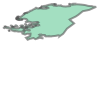

In [10]:
poly

With this in hand, I can read in a shapefile of destinations - here, the churches in Iceland. I use shapely's 'within' command to select just those in the Reykjavik area:

In [13]:
churches = gpd.read_file(os.path.join(pth, 'tutorial_data', 'churches.shp'))
churches = churches.loc[churches.within(poly)]

I want to know the closest network node to each church. For this, we use pandana snap to snap the church locations to the road network:

In [14]:
churches = gn.pandana_snap(G_time, churches, add_dist_to_node_col = True)

As we can see from the NN_dist column, our church locations are very close to a node on the network in all cases

In [15]:
churches

,osm_id,code,fclass,name,geometry,NN,NN_dist
0,59983337,3104,christian_lutheran,Grafarvogskirkja,POINT (-21.7996815 64.1324111),1057,0.000274
2,319768632,3300,muslim,Félag Múslima á Íslandi,POINT (-21.8757482 64.13430150000001),4312,0.000288
11,1866767163,3100,christian,Betanía,POINT (-21.8146273 64.1234264),4701,0.000330
13,3030668954,3103,christian_evangelical,Biskup Íslands,POINT (-21.9274452 64.1454145),11173,0.000163
14,3030668955,3103,christian_evangelical,Biskupsstofa,POINT (-21.9274297 64.14541149999999),11173,0.000149
15,3030668961,3103,christian_evangelical,Kirkjuráð,POINT (-21.92744 64.1454135),11173,0.000158
16,3030668966,3103,christian_evangelical,Skálholtsútgáfan,POINT (-21.9274346 64.1454124),11173,0.000153
19,3761680070,3100,christian,Alþjóðleg kirkja Guðs og embætti Jesú Krists,POINT (-21.9052665 64.14133),10771,0.000361
20,3975889251,3100,christian,Parohia Ortodoxă Română Reykjavik,POINT (-21.9532903 64.15002010000001),3642,0.000339


When calculating an OD-Matrix, we can only use the node IDs as inputs. So, we convert this column of our dataframe over to a list of unique values:

In [16]:
destinations = list(set(list(churches.NN)))

At this point, we have a choice to make. If we know our origins, we can use gn.calculate_OD() to calculate the OD matrix from each origin to all destinations. 

If we do not have fixed origins in mind, we could also visualize the isochrones around the network itself, with gn.make_iso_polys. Here, I generate a polygon geodataframe of the isochrones around the churches, at the 5, 10 and 15 minute travel time intervals. 

I have chosen to buffer each edge by 10m, and each node by 25m, to make the visualization. I am measuring in the nearest UTM zone with my choice of measure_crs. 

N.B. Please note - this step takes a while. If you want to speed it up, reduce the trip times options down somewhat. Here, I am generating 5 minute, 10 minute and 15 minute drive time isochrones.

In [17]:
isopolys = gn.make_iso_polys(G_time, 
                  destinations, 
                  trip_times = [5*60, 10*60, 15*60], 
                  edge_buff=10, 
                  node_buff=25, 
                  infill=False, 
                  weight = 'time', 
                  measure_crs = {'init': 'epsg:32627'})

I can cheaply visualize them here with geopandas' plot method:

In [18]:
isopolys.plot()

Or, save them down to visualize in QGIS, after resetting the crs to WGS 84 for ease of use:

In [19]:
isopolys = isopolys.to_crs({'init': 'epsg:4326'})
isopolys.to_csv(os.path.join(pth, 'tutorial_outputs', 'church_isopolys.csv'))

Note, we could, with a little extra work transform the pandas dataframe into a geopandas GeoDataFrame, and then send this to file as a geoJSON or shapefile. 

Next, I decide I would like to make an OD-matrix where the origin is the cottage I am renting in the city, and the destinations are the churches in Reykjavik. This will help me to wok out how many churches I can see today!. First, I need to create my origin. It has coordinates: 64.152215, -22.002099, so I make a point of this:

In [20]:
my_house = [Point(64.152215, -22.002099)]

Next, I load it into a geodataframe and snap it to the network:

In [21]:
mini_gdf = gpd.GeoDataFrame({'point':my_house}, crs = {'init':'epsg:4326'}, geometry = 'point', index = [1])

In [22]:
mini_gdf

,point
1,POINT (64.152215 -22.002099)


In [23]:
origin_gdf = gn.pandana_snap(G_time, mini_gdf)

In [24]:
origin_gdf

,point,x,y,NN
1,POINT (64.152215 -22.002099),64.152215,-22.002099,2129


Now, I can calcuate my OD-matrix using GN.calculate_OD(). Bear in mind it takes list objects as inputs:

In [25]:
origin = [2129]
OD = gn.calculate_OD(G_time, origin, destinations, fail_value = 9999999)

I can convert this nicely into a pandas Dataframe, using minutes as the measure as so:

In [26]:
OD = OD / 60
OD_df = pd.DataFrame(OD, columns = destinations, index = origin)

In [27]:
OD_df

,1057,11173,10771,4312,3642,4701
2129,61.800695,67.795365,65.371649,62.85668,69.637363,57.393223


It appears nearly all of the churches are an hour's drive away...perhaps I will have a beer instead.

Now that you are up to speed on the basics, check out some of the example notebooks in the 'Notebooks' folder.

~fin~